In [179]:
import os
import sys

sys.path.append("../python")

import matplotlib.pyplot as plt
import numpy as np
import importlib


In [180]:
from data import Dataloader
from models import RandomExampleModel, TwoClustersMIP
import metrics

## MIP

In [19]:
# Loading the data
data_loader = Dataloader("../data/dataset_4") # Specify path to the dataset you want to load
X, Y = data_loader.load()


In [20]:
P, n = X.shape
K = 2
L = 10

In [21]:
len([(j, k) for j in range(2000) for k in range(2)])

4000

In [22]:
# P2 = 1000
# X,Y = X[:P2,:], Y[:P2,:]

In [23]:
importlib.reload(importlib.import_module('models'))
from models import RandomExampleModel, TwoClustersMIP

In [24]:
# Let's train an example model
model = TwoClustersMIP(n_pieces=L,n_clusters=K,n_criterions=n,n_pairs=P) # Instantiation of the model with hyperparameters, if needed
model.fit(X, Y) # Training of the model, using preference data

Set parameter Seed to value 123
Fitting the model
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.2.0 24C101)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
Seed  123

Optimize a model with 6084 rows, 8088 columns and 69634 nonzeros
Model fingerprint: 0xe1f3f469
Variable types: 4088 continuous, 4000 integer (4000 binary)
Coefficient statistics:
  Matrix range     [1e-05, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 2e+00]
Found heuristic solution: objective 107.4285617
Presolve removed 2010 rows and 2008 columns
Presolve time: 0.10s
Presolved: 4074 rows, 6080 columns, 62232 nonzeros
Variable types: 4080 continuous, 2000 integer (2000 binary)

Root relaxation: objective 0.000000e+00, 1316 iterations, 0.09 seconds (0.14 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth In

In [ ]:
print(model.predict_utility(X))

[[0.96294235 0.98477362]
 [0.85708385 0.58999745]
 [0.76711726 0.51634023]
 ...
 [0.75134051 0.9934796 ]
 [0.74367959 0.9869709 ]
 [0.64978905 0.98801428]]


In [117]:
# First, let's see how our model reconsiders our preferences
# Our data preferences were X[i] >> Y[i] for all i, let's see if our model agrees
print((model.predict_utility(X) - model.predict_utility(Y))[:5]) # Preferred item has a higher utility

# predict_utility returns utility of samples for each cluster, returning shape (n_samples, n_clusters)

[[ 0.15147149 -0.01389374]
 [ 0.0950977  -0.38183603]
 [ 0.08881266 -0.49915283]
 [-0.04444407  0.25828882]
 [ 0.07673449 -0.00146251]]


In [118]:
# Or we can directly use the predict_preference method:
print(model.predict_preference(X, Y)[:5]) # For each cluster we see if X is preferred to Y (0) or the contrary (1)
# predict_preference returns preference of samples for each cluster, returning shape (n_samples, n_clusters)
# 0 means that the cluster prefers first argument (here X[i]), 1 means that the cluster prefers second argument (here Y[i])

[[1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]]


In [119]:
# We consider that our model explains our data, if for at least one cluster, X[i] >> Y[i]
pairs_explained = np.sum(model.predict_preference(X, Y)[:5] == 0, axis=1) # For each sample check if each clusters prefers X[i] (then is True)
pairs_explained = pairs_explained > 0 # If at least one cluster prefers X[i], then X[i] >> Y[i] is explained
print("Percentage of explained preferences for 5 first samples:", np.sum(pairs_explained) / 5) # Get % or explained pairs

Percentage of explained preferences for 5 first samples: 1.0


In [120]:
# Or we call directly the right metric:
pairs_explained = metrics.PairsExplained()
print("Percentage of explained preferences for all samples:", pairs_explained.from_model(model, X, Y))
# Or other possibility:
print("Percentage of explained preferences for all samples:", pairs_explained(model.predict_utility(X), model.predict_utility(Y)))

Percentage of explained preferences for all samples: 0.989
Percentage of explained preferences for all samples: 0.989


In [121]:
# Now, we can also see how our model clusters our data
print(model.predict_cluster(X, Y)[:5]) # Returns for each sample which cluster is the most likely to have generated the preference.
# The most likely cluster is the one with the highest utility difference U(X[i])-U(Y[i]) for the sample.

[0 0 0 1 0]


In [122]:
# Ground truth are also provided:
Z = data_loader.get_ground_truth_labels()
# We can see how it compares to our model's predictions:
print(Z[:5])

[0 0 0 1 0]


In [123]:
# We have a metric to calculate how well the model has regrouped the preferences pairs compared to ground truth:
cluster_intersection = metrics.ClusterIntersection()

print("Cluster intersection for 5 first samples:", cluster_intersection(model.predict_cluster(X, Y)[:5], Z[:5]))

# Then for all data:
print("Cluster intersection for all samples:", cluster_intersection(model.predict_cluster(X, Y), Z))
print("Cluster intersection for all samples:", cluster_intersection.from_model(model, X, Y, Z))

Cluster intersection for 5 first samples: 1.0
Cluster intersection for all samples: 0.983136068034017
Cluster intersection for all samples: 0.983136068034017


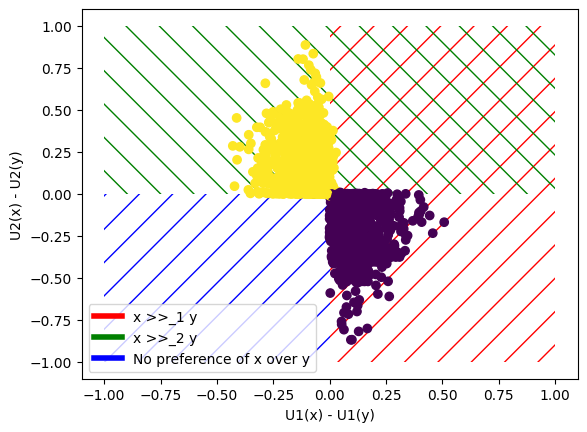

In [125]:
# Here is a proposition of a useful plot to see how the model clusters the data:
# We look at how each cluster evaluates U(x) - U(y) and color with ground truth clustering
# Note that x >>_1 y means that x is preferred to y for cluster 1
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

plt.figure()
plt.xlabel("U1(x) - U1(y)")
plt.ylabel("U2(x) - U2(y)")

plt.gca().add_patch(Rectangle((0,-1.),1., 2.,
                    edgecolor='red',
                    facecolor='none',
                    lw=0, 
                    hatch='/'))
plt.gca().add_patch(Rectangle((-1.,0), 2., 1.,
                    edgecolor='green',
                    facecolor='none',
                    lw=0, 
                    hatch='\\'))
plt.gca().add_patch(Rectangle((-1.,-1.),1., 1.,
                    edgecolor='blue',
                    facecolor='none',
                    hatch='/',
                    lw=0))
plt.scatter(model.predict_utility(X)[:, 0]-model.predict_utility(Y)[:, 0], 
            model.predict_utility(X)[:, 1]-model.predict_utility(Y)[:, 1], c=Z[:P])

custom_lines = [Line2D([0], [0], color="red", lw=4),
                Line2D([0], [0], color="green", lw=4),
                Line2D([0], [0], color="b", lw=4)]

plt.legend(custom_lines, ['x >>_1 y', "x >>_2 y ", 'No preference of x over y'])
plt.show()

Our random model cannot explain a large part of our preference data. Your first assigment will be to write a Mixed-Interger Programming algorithm that will be able to do so.

In [16]:
# This cell should work when you have completed the TwoClustersMIP model
from models import TwoClustersMIP

parameters = {"n_pieces": 5, "n_clusters": 2} # Can be completed
model = TwoClustersMIP(**parameters)
model.fit(X, Y)

# Uncomment once your model is working
# print("Percentage of explained preferences on train data:", pairs_explained.from_model(model, X, Y)) # You should get 1.0 with the right MIP
# print("Percentage of preferences well regrouped into clusters:", cluster_intersection.from_model(model, X, Y, Z))

fitting


KeyError: (5, 0)

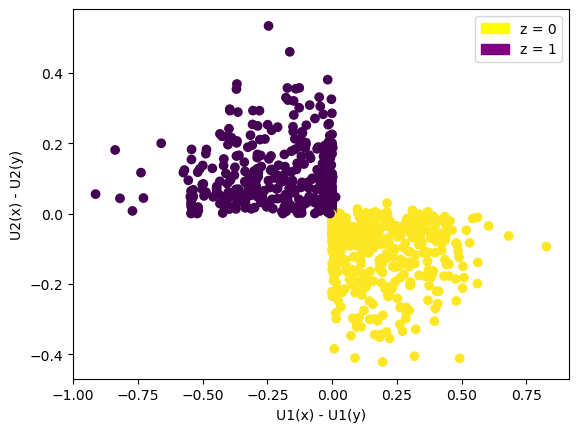

In [76]:
# As an example here are the results obtained with:
""" # Uncomment the code to check your results
plt.figure()
plt.scatter(model.predict_utility(X)[:, 0]-model.predict_utility(Y)[:, 0], 
            model.predict_utility(X)[:, 1]-model.predict_utility(Y)[:, 1], c=Z)
plt.xlabel("U1(x) - U1(y)")
plt.ylabel("U2(x) - U2(y)")
plt.show()
"""
# Here is how it should look like
from IPython.display import Image
Image("../images/MIP_results_example.png")

## Heuristic

Your second assignement will be to find a model that will work well with larger data instances.

In [181]:
from choice_learn.datasets import load_car_preferences
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

In [182]:
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

# Fonction pour déplacer le 1 sur une autre colonne de manière aléatoire
def changement_cluster(matrice, vecteur):
    t, n = matrice.shape
    for i in range(t):
        if vecteur[i]:  # Si le vecteur est True pour cette ligne
            # Trouver l'index de la colonne où le 1 est situé
            col_1 = np.argmax(matrice[i, :])  # Trouver la colonne contenant le 1
            # Choisir une nouvelle colonne aléatoire (différente de la colonne actuelle)
            nouvelles_cols = list(range(n))
            nouvelles_cols.remove(col_1)
            nouvelle_col = np.random.choice(nouvelles_cols)
            # Réinitialiser la ligne et placer le 1 à la nouvelle colonne
            matrice[i, :] = 0
            matrice[i, nouvelle_col] = 1
    return matrice

def plot_2D(predict_utility_X,predict_utility_Y):
    plt.figure()
    plt.xlabel("U1(x) - U1(y)")
    plt.ylabel("U2(x) - U2(y)")

    plt.gca().add_patch(Rectangle((0,-1.),1., 2.,
                        edgecolor='red',
                        facecolor='none',
                        lw=0, 
                        hatch='/'))
    plt.gca().add_patch(Rectangle((-1.,0), 2., 1.,
                        edgecolor='green',
                        facecolor='none',
                        lw=0, 
                        hatch='\\'))
    plt.gca().add_patch(Rectangle((-1.,-1.),1., 1.,
                        edgecolor='blue',
                        facecolor='none',
                        hatch='/',
                        lw=0))
    plt.scatter(predict_utility_X[:, 0]-predict_utility_Y[:, 0], 
                predict_utility_X[:, 1]-predict_utility_Y[:, 1], c=Z[:P,0])

    custom_lines = [Line2D([0], [0], color="red", lw=4),
                    Line2D([0], [0], color="green", lw=4),
                    Line2D([0], [0], color="b", lw=4)]

    plt.legend(custom_lines, ['x >>_1 y', "x >>_2 y ", 'No preference of x over y'])
    plt.show()

In [183]:
df = load_car_preferences(as_frame=True)
df = df.loc[:, ~df.columns.str.startswith(('type', 'fuel'))]
df.rename(columns={'hsg2': 'hsg', 'coml5': 'coml'}, inplace=True)
df

,rownames,choice,college,hsg,coml,price1,price2,price3,price4,price5,...,cost3,cost4,cost5,cost6,station1,station2,station3,station4,station5,station6
0,1,choice1,0,0,0,4.175345,4.175345,4.817706,4.817706,5.138886,...,6,6,8,8,0.1,0.1,0.3,0.3,1.0,1.0
1,2,choice2,1,1,1,3.310947,3.310947,3.586859,3.586859,4.414596,...,8,8,4,4,0.0,0.0,0.1,0.1,1.0,1.0
2,3,choice5,0,1,0,4.039574,4.039574,2.777207,2.777207,3.282154,...,8,8,2,2,0.1,0.1,0.3,0.3,1.0,1.0
3,4,choice5,0,0,1,7.065968,7.065968,7.387149,7.387149,5.460066,...,2,2,4,4,0.0,0.0,0.7,0.7,0.1,0.1
4,5,choice5,0,1,0,5.794157,5.794157,6.345981,6.345981,4.690508,...,8,8,2,2,0.3,0.3,0.7,0.7,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4649,4650,choice5,1,0,0,3.534628,3.534628,3.787101,3.787101,4.039574,...,8,8,2,2,0.0,0.0,0.1,0.1,0.3,0.3
4650,4651,choice3,0,1,0,3.086326,3.086326,3.561146,3.561146,3.798555,...,4,4,6,6,0.1,0.1,0.3,0.3,1.0,1.0
4651,4652,choice3,1,1,0,5.554415,5.554415,5.806888,5.806888,4.796995,...,4,4,8,8,0.0,0.0,0.1,0.1,1.0,1.0
4652,4653,choice3,1,0,0,3.532984,3.532984,1.927082,1.927082,2.248263,...,4,4,6,6,0.0,0.0,0.7,0.7,0.1,0.1


In [184]:
X = pd.DataFrame(columns=['price', 'range', 'acc', 'speed','pollution', 'size', 'space', 'cost','station'])
Y = pd.DataFrame(columns=['price', 'range', 'acc', 'speed','pollution', 'size', 'space', 'cost','station'])
Z_ = pd.DataFrame(columns=['college', 'hsg', 'coml'])
for i in range(df.shape[0]):
    choice = int(df.loc[i, 'choice'].replace("choice", ""))
    df_X = pd.DataFrame(df.loc[i, df.columns.str.endswith(str(choice))]).T
    df_X.columns = list(X.columns)
    for j in range(1,7):
        if j!= choice :
            df_Y = pd.DataFrame(df.loc[i, df.columns.str.endswith(str(j))]).T
            df_Y.columns = list(Y.columns)

            X = pd.concat([X,df_X], ignore_index=True)
            Y = pd.concat([Y,df_Y], ignore_index=True)
            Z_ = pd.concat([Z_, pd.DataFrame(df.loc[i, list(Z_.columns)]).T], ignore_index=True)

X = (X - X.min()) / (X.max() - X.min())
Y = (Y - Y.min()) / (Y.max() - Y.min())

for param_to_invert in ['price','pollution','cost']:
    X[param_to_invert]= 1 - X[param_to_invert]
    Y[param_to_invert]= 1 - Y[param_to_invert]

X = np.array(X)
Y = np.array(Y)

In [185]:
P, n = X.shape
K = 2
L = 10

max_iter = 3

In [186]:
importlib.reload(importlib.import_module('models'))
from models import HeuristicModel

Set parameter Seed to value 123
Fitting the model
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.2.0 24C101)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
Seed  123

Optimize a model with 46724 rows, 46738 columns and 891308 nonzeros
Model fingerprint: 0xdb44706f
Coefficient statistics:
  Matrix range     [2e-03, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 2e+00]
Presolve removed 9382 rows and 9380 columns
Presolve time: 0.29s
Presolved: 37342 rows, 37358 columns, 788602 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.102e+03
 Factor NZ  : 3.306e+03 (roughly 7 MB of memory)
 Factor Ops : 1.267e+05 (less than 1 second per iteration)
 Threa

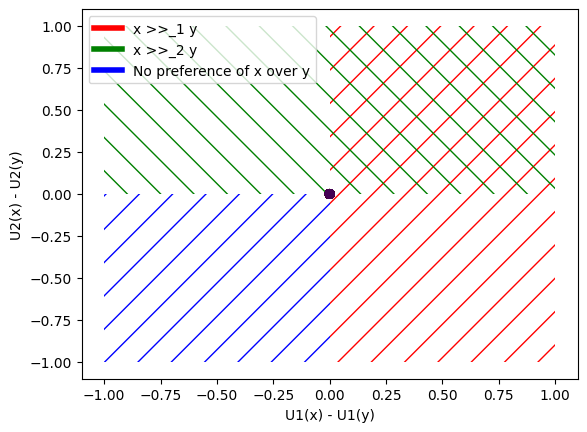

Set parameter Seed to value 123
Fitting the model
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


KeyboardInterrupt: 

In [187]:
kmeans = KMeans(n_clusters=K, random_state=0)
Z = kmeans.fit_predict(Z_[['college', 'hsg', 'coml']])
unique_values = np.unique(Z)
Z = np.array([Z == val for val in unique_values]).T.astype(int)

iter = 0
while iter < max_iter :
    
    model = HeuristicModel(n_pieces=L,n_clusters=K,n_criterions=n,n_pairs=P,Z=Z)
    model.fit(X, Y)

    predict_utility_X = model.predict_utility(X)
    predict_utility_Y = model.predict_utility(Y)
    vect = np.any(predict_utility_X-predict_utility_Y < 0, axis=1)

    plot_2D(predict_utility_X,predict_utility_Y)

    Z = changement_cluster(Z.copy(), vect)

    iter+=1